# Demo notebook: Tiled GEDI dataset on the MAAP

## 1. Database layout and Geopandas access

This notebook demonstrates the capabilities of the tiled GEDI dataset: a (moderately) filtered copy of the GEDI data that is spatiotemporally sorted into tiles covering 1º x 1º x 1 year.

The database is hosted at: 
`s3://maap-ops-workspace/shared/ameliah/gedi-test/brazil_tiles/data`

Currently, the database was constructed to the following specification:
- All GEDI footprints from 2019 - 2023 (first phase of the GEDI mission)
- Version 2.1
- Products L2A, L2B, L4A, and L4C, joined on shot_number
- Footprints are pre-filtered for:
    - Level 2A quality_flag == 1 (** n.b. this is not the same as the L4A flag "l2a_quality_flag")
    - 0.9 <= sensitivity_a0 <= 1
    - 0.95 < sensitivity_a2 <= 1
    - degrade_flag %in% [0, 3, 8, 10, 13, 18, 20, 23, 28, 30, 33, 38, 40, 43, 48, 60, 63, 68]
    - surface_flag == 1
- If a footprint is not present in all four products, it will not be present in the database.

The database currently covers Brazil only. Brazil is divided into 818 1ºx1º tiles as shown below:

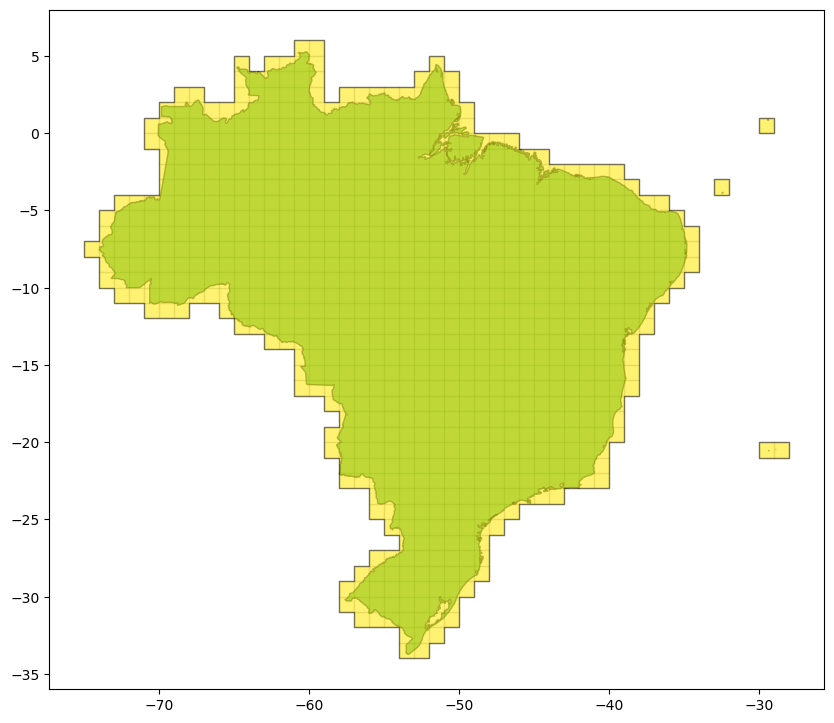

Tiles are named in the format `[NS][##]_[EW][###]`, specifying the top left corner of the tile.

Thus, S21_W049 covers latitudes in the range [-21, -22) and longitudes in the range [-49, -48).
Data for a given tile is found in named subdirectories, e.g. `brazil_tiles/data/tile_id=S21_W049`

Tiles are further subdivided into years (2019-2023), which are similarly named subdirectories.
Leaf files are called `data_0.parquet`.
So, for example, the GEDI data for the year 2020 in the tile S21_W049 can be read with geopandas as follows:

In [2]:
# It takes about 1.5 minutes to load 539273 rows x 280 columns
import geopandas as gpd
BUCKET = "maap-ops-workspace"
PREFIX = "shared/ameliah/gedi-test/brazil_tiles"
file_path = f"s3://{BUCKET}/{PREFIX}/data/tile_id=S21_W049/year=2020/data_0.parquet"
gdf = gpd.read_file(file_path)
gdf

,shot_number,elev_lowestmode,delta_time,sensitivity,sensitivity_a1,sensitivity_a2,degrade_flag,quality_flag,landsat_treecover,modis_treecover,modis_treecover_sd,modis_nonvegetated,modis_nonvegetated_sd,solar_elevation,solar_azimuth,...,pft_class,region_class,wsci,wsci_pi_lower,wsci_pi_upper,wsci_quality_flag,wsci_xy,wsci_xy_pi_lower,wsci_xy_pi_upper,wsci_z,wsci_z_pi_lower,wsci_z_pi_upper,granule,absolute_time,geometry
0,1.133200e+17,729.506226,9.299882e+07,0.964359,0.882893,0.964359,0,1,0.0,10.0,8.82,11.0,8.82,6.904153,112.205612,...,2,6,8.499086,5.630302,11.367870,0,5.515583,3.544855,7.486311,4.595208,3.053097,6.137319,O11332_01,2020/12/12 09:00:22.772+00,POINT (-48.10459 -21.95629)
1,1.133200e+17,646.661804,9.299882e+07,0.959767,0.897588,0.959767,0,1,97.0,43.0,2.57,3.0,2.57,6.944648,112.187065,...,2,6,8.232241,5.363457,11.101025,0,5.370342,3.399613,7.341070,4.454102,2.911991,5.996213,O11332_01,2020/12/12 09:00:24.639+00,POINT (-48.02565 -21.86629)
2,1.133200e+17,645.433777,9.299882e+07,0.969505,0.915292,0.969505,0,1,98.0,43.0,2.57,3.0,2.57,6.944829,112.186989,...,2,6,8.056960,5.188176,10.925744,0,5.214051,3.243323,7.184780,4.289548,2.747437,5.831659,O11332_01,2020/12/12 09:00:24.648+00,POINT (-48.0253 -21.86589)
3,1.133200e+17,672.493530,9.299882e+07,0.966999,0.911996,0.966999,0,1,89.0,64.0,2.08,3.0,2.08,6.946616,112.186172,...,2,6,10.615269,10.168788,11.061749,0,6.087779,5.897876,6.277681,6.141482,5.828865,6.454099,O11332_01,2020/12/12 09:00:24.730+00,POINT (-48.0218 -21.86191)
4,1.133200e+17,675.650696,9.299882e+07,0.960814,0.891151,0.960814,0,1,87.0,64.0,2.08,3.0,2.08,6.946798,112.186089,...,2,6,10.084033,9.355283,10.812783,0,6.083204,5.889909,6.276500,5.722519,5.165794,6.279245,O11332_01,2020/12/12 09:00:24.739+00,POINT (-48.02145 -21.86151)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539268,9.846060e+16,645.538452,8.472003e+07,0.970379,0.970379,0.987191,0,1,0.0,6.0,10.63,21.0,10.63,51.465973,48.691948,...,8,6,6.968504,4.357381,9.579628,0,4.348928,2.360950,6.336906,3.782190,2.321700,5.242679,O09846_04,2020/09/07 13:20:33.112+00,POINT (-48.46104 -21.33215)
539269,9.846060e+16,646.080933,8.472003e+07,0.970344,0.970344,0.988467,0,1,0.0,6.0,10.63,21.0,10.63,51.465973,48.691139,...,8,6,7.013234,4.402111,9.624357,0,4.382907,2.394928,6.370885,3.805004,2.344515,5.265494,O09846_04,2020/09/07 13:20:33.120+00,POINT (-48.4607 -21.33255)
539270,9.846060e+16,646.541626,8.472003e+07,0.965159,0.965159,0.985483,0,1,0.0,6.0,10.63,21.0,10.63,51.465977,48.690331,...,8,6,6.998602,4.387479,9.609726,0,4.373625,2.385647,6.361604,3.823629,2.363140,5.284119,O09846_04,2020/09/07 13:20:33.129+00,POINT (-48.46035 -21.33295)
539271,9.846060e+16,647.296692,8.472003e+07,0.972745,0.972745,0.991741,0,1,0.0,19.0,9.05,17.0,9.05,51.465981,48.689522,...,8,6,6.947357,4.336234,9.558481,0,4.261756,2.273777,6.249734,3.810590,2.350100,5.271079,O09846_04,2020/09/07 13:20:33.137+00,POINT (-48.46001 -21.33335)


However, Geopandas is a relatively inefficient way to work with large datasets. The tiled GEDI dataset is laid out in a format such that many data processing frameworks, such as DuckDB, Spark, Dask, etc. will be able to quickly scan and query the data. You can use these tools alone or in combination with Geopandas -- for example, pulling the data from the database with a fast query framework and then converting it to geopandas for further processing.

Below is an introduction to using [DuckDB](https://duckdb.org) to work with the GEDI data.

## 2. DuckDB access

DuckDB is a query engine that supports efficient querying of large datasets split among many files.
It queries using SQL, a standard language for interacting with tabular data. 
The DuckDB SQL API docs are [here](https://duckdb.org/docs/stable/sql/introduction),
and generally most internet advice for SQL (especially the dialect called "PostgreSQL") will also work in DuckDB.

DuckDB also can be used in R with the package `duckplyr`. All the SQL commands shown below will be the same in R, 
but instead of `con.sql("SQL COMMAND")` you will run `dbGetQuery(con, "SQL COMMAND")`.
For more details, see the R client API docs [here](https://duckdb.org/docs/stable/clients/r.html).

We start out by creating a duckDB connection and telling it where our database is located.

In [1]:
# A convenience library that sets up DuckDB with appropriate configuration
# for the Tiled GEDI database.
from gtiler.database import ducky
con = ducky.init_duckdb()

# data_spec is a string telling duckDB the location and layout of the database
BUCKET = "maap-ops-workspace"
PREFIX = "shared/ameliah/gedi-test/brazil_tiles"
data_spec = ducky.data_spec(BUCKET, PREFIX)
data_spec

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

's3://maap-ops-workspace/shared/ameliah/gedi-test/brazil_tiles/data/*/*/*.parquet'

### SQL: SELECT and FROM

In [2]:
# The simplest SQL query has two clauses: SELECT and FROM
# SELECT specifies which columns to return
# FROM specifies which table to query

# Try modifying the list of columns below to see what else is available in the database.
# Use "SELECT * FROM ..." to see all columns.
# Try a mistyped column name (like "SELECT rh_098 FROM ...") to see how DuckDB reports errors.

con.sql(f"""
    SELECT shot_number, agbd, rh_98, l4_quality_flag, geometry
    FROM read_parquet('{data_spec}')
""")

┌───────────────────┬───────────┬───────┬─────────────────┬────────────────────────────────────────────────┐
│    shot_number    │   agbd    │ rh_98 │ l4_quality_flag │                    geometry                    │
│      uint64       │   float   │ float │      uint8      │                    geometry                    │
├───────────────────┼───────────┼───────┼─────────────────┼────────────────────────────────────────────────┤
│ 33771100400270971 │       0.0 │  2.51 │               1 │ POINT (-46.9946661103302 -0.97584802727075)    │
│ 33771100400270972 │       0.0 │  2.43 │               1 │ POINT (-46.99436888763849 -0.976269963621268)  │
│ 33771100400270973 │       0.0 │  2.39 │               1 │ POINT (-46.99407165518076 -0.976691896036926)  │
│ 33771100400270974 │       0.0 │  2.47 │               1 │ POINT (-46.993774420470956 -0.977113822443567) │
│ 33771100400270975 │       0.0 │  2.36 │               1 │ POINT (-46.99347716587506 -0.977535748549778)  │
│ 33771100400270976

A few things to notice about the above query:
- It's very fast (~2 seconds). No individual tile was fully loaded into memory to produce the output
- It's not showing all the data, just a preview of 20 rows
- We used the special function `read_parquet` to read all the parquet files matching `data_spec` into one DuckDB table
- The database includes a `geometry` column, which contains a spatial datatype. This is `POINT(lon_lowestmode, lat_lowestmode)`

### SQL: WHERE

In [3]:
# We can now add a third SQL clause: WHERE
# WHERE specifies a filter condition that rows must meet to be included in the output
# Feel free to modify the filter condition below and test the changes to the output
# For example, try a filter that compares two different columns

con.sql(f"""
    SELECT shot_number, agbd, rh_98, l4_quality_flag, geometry
    FROM read_parquet('{data_spec}')
    WHERE l4_quality_flag = 1 AND agbd > 25
""")

┌────────────────────┬───────────┬───────┬─────────────────┬────────────────────────────────────────────────┐
│    shot_number     │   agbd    │ rh_98 │ l4_quality_flag │                    geometry                    │
│       uint64       │   float   │ float │      uint8      │                    geometry                    │
├────────────────────┼───────────┼───────┼─────────────────┼────────────────────────────────────────────────┤
│  44150100400270682 │ 33.593822 │ 12.96 │               1 │ POINT (-47.595040377365514 -0.837991016044682) │
│  44150100400270683 │ 43.958824 │ 13.85 │               1 │ POINT (-47.594743838319694 -0.838412764376955) │
│  44150100400270701 │  78.63961 │ 18.35 │               1 │ POINT (-47.589398408836 -0.846009052572055)    │
│  44150100400270702 │  95.58385 │  20.6 │               1 │ POINT (-47.58910117472862 -0.84643143683865)   │
│  44150100400270706 │ 42.625683 │ 14.38 │               1 │ POINT (-47.58791286876466 -0.848118767666564)  │
│  4415010

In [ ]:
# SELECT statements can also include computed columns
# See https://duckdb.org/docs/stable/sql/functions/
# It is also possible to write your own functions in Python and register them with DuckDB,
# though you will find that many useful functions are already built-in.

# Here, we compute the mean AGBD and RH 98 for high-quality shots in a specific tile.

con.sql(f"""
    SELECT MEAN(agbd), MEAN(rh_98)
    FROM read_parquet('{data_spec}')
    WHERE l4_quality_flag = 1 AND tile_id = 'S21_W049'
""")


┌────────────────────┬───────────────────┐
│     mean(agbd)     │    mean(rh_98)    │
│       double       │      double       │
├────────────────────┼───────────────────┤
│ 12.232413338670174 │ 5.294282060142416 │
└────────────────────┴───────────────────┘

#### Spatial querying

This is a spatial database, so we can also run spatial queries on the data.
A list of spatial functions supported by DuckDB can be found [here](https://duckdb.org/docs/stable/core_extensions/spatial/functions.html). 

The explanation of these spatial functions in the docs is pretty sparse, but they work
the same as in PostGIS, so you can consult the PostGIS documentation [here](https://postgis.net/docs/manual-3.6/reference.html) to understand what each function does (with pictures!)


Note that not all PostGIS functions are implemented in DuckDB.

Probably the most useful function is `ST_Contains()`, which you can use to query the GEDI footprints for an AOI.

In [4]:
# Start by creating an example shapefile for an AOI that crosses four tiles.
# We are making a simple bounding box, but you can use any shapefile here.
from shapely.geometry import box

region_gdf = gpd.GeoDataFrame(geometry=[box(-63.2, -4.2, -62.8, -3.8)], crs="EPSG:4326")
region_gdf.to_file("/projects/my-public-bucket/shapefiles/test_region.shp")

In [5]:
# Read the shapefile into DuckDB
# SELECT * reads all columns
# ST_Read is a special function to read shapefiles (similar to read_parquet, which we used earlier)
region_df = con.sql("SELECT * FROM ST_Read('/projects/my-public-bucket/shapefiles/test_region.shp')")
region_df

┌───────┬────────────────────────────────────────────────────────────────────────┐
│  FID  │                                  geom                                  │
│ int64 │                                geometry                                │
├───────┼────────────────────────────────────────────────────────────────────────┤
│     0 │ POLYGON ((-62.8 -4.2, -63.2 -4.2, -63.2 -3.8, -62.8 -3.8, -62.8 -4.2)) │
└───────┴────────────────────────────────────────────────────────────────────────┘

In [6]:
# Now we'll compute the average AGBD and RH 98 for high-quality shots within the AOI

# For spatial queries, we can speed them up considerably with a tile filter clause.
# See "Query speed and optimization" below for the explanation, but for now --
# Use `ducky.spatial_filter_clause(shp)` to get a SQL clause telling DuckDB 
# which tiles to search in. This speeds up the query from minutes to seconds.
fast_filter = ducky.spatial_filter_clause(region_gdf)

# Now we run the spatial query
con.sql(f"""
        SELECT MEAN(agbd), MEAN(rh_98), COUNT(shot_number)
        FROM read_parquet('{data_spec}') AS d, region_df AS r
        WHERE ST_Contains(r.geom, d.geometry) AND l4_quality_flag = 1 AND ({fast_filter})
        """)

# REMINDER: If your shapefile is in a different CRS, be sure to reproject the GEDI geometry column to match,
# e.g. ST_Contains(r.geom, ST_Transform(d.geometry, 'EPSG:4326', 'your-crs-here'))

┌────────────────────┬───────────────────┬────────────────────┐
│     mean(agbd)     │    mean(rh_98)    │ count(shot_number) │
│       double       │      double       │       int64        │
├────────────────────┼───────────────────┼────────────────────┤
│ 125.54187008430274 │ 20.80863550482044 │              53236 │
└────────────────────┴───────────────────┴────────────────────┘

A few tricks to notice in the query above:
- In the FROM clause, we added another table: region_df
- We used `ducky.spatial_filter_clause` as a fast filter to help DuckDB quickly identify the relevant files. See "Query speed and optimization", below, for details.
- We used "AS" to rename our variables. This lets us easily reference them again elsewhere in the query by a short variable name
- In the "WHERE" clause, we now specify which table the column comes from using "." For example, d.geometry references the geometry column in the table named "d". We could also include this in the rest of the query (e.g. `d.agbd, d.rh_98, d.shot_number`, etc., but the table name can be omitted IF there are no columns with the same name in multiple tables.)

### SQL: GROUP BY

The final type of SQL clause we will introduce in this demo is GROUP BY.
This is used to aggregate data based on a single key and compute a summary.

For example, let's say we were running an analysis on phenology with GEDI,
and we wanted to understand how biomass and pai varied from month to month in our AOI.

We want the mean biomass and pai _grouped by_ the month in which the GEDI shot was collected.

In [9]:
# absolute_time is a timestamp column giving the date and time of each shot
# DATE_PART is a built-in function that extracts part of a timestamp (e.g. year, month, day, hour, etc.)
# See https://duckdb.org/docs/stable/sql/functions/datetime

con.sql(f"""
        SELECT
            MEAN(agbd),
            MEAN(pai),
        FROM read_parquet('{data_spec}') AS d, region_df AS r
        WHERE l4_quality_flag = 1 AND ST_Contains(r.geom, d.geometry) AND ({fast_filter})
        GROUP BY DATE_PART('month', absolute_time)
        """)

┌────────────────────┬────────────────────┐
│     mean(agbd)     │     mean(pai)      │
│       double       │       double       │
├────────────────────┼────────────────────┤
│   120.741287507591 │ 2.8538512254157813 │
│ 119.47871183088803 │ 3.0687753763540226 │
│ 181.68983351665995 │ 3.6196915896042534 │
│  86.21296011897896 │ 2.3934141616446887 │
│   91.1950243222979 │  2.411827307974821 │
│ 166.54189448218418 │ 3.6789607549931165 │
│ 142.17775347862334 │ 3.2759549969039625 │
│ 113.42279633753517 │  2.754164984760619 │
│  96.86361327499682 │  2.574946743907004 │
│ 132.23756975663218 │ 2.9901523928873384 │
│ 126.30922107474062 │ 2.8232617386878447 │
├────────────────────┴────────────────────┤
│ 11 rows                       2 columns │
└─────────────────────────────────────────┘

Hmm, to make that a little clearer, let's add a column showing which month each 
row corresponds to, sorting the months in order.

We'll use "AS" to make this easier to read.

In [10]:
con.sql(f"""
        SELECT
            DATE_PART('month', absolute_time) AS month,
            MEAN(agbd),
            MEAN(pai),
        FROM read_parquet('{data_spec}') AS d, region_df AS r
        WHERE l4_quality_flag = 1 AND ST_Contains(r.geom, d.geometry) AND ({fast_filter})
        GROUP BY month
        ORDER BY month
        """)

┌───────┬────────────────────┬────────────────────┐
│ month │     mean(agbd)     │     mean(pai)      │
│ int64 │       double       │       double       │
├───────┼────────────────────┼────────────────────┤
│     1 │   91.1950243222979 │  2.411827307974821 │
│     2 │  86.21296011897896 │ 2.3934141616446887 │
│     3 │ 181.68983351665995 │ 3.6196915896042534 │
│     4 │ 132.23756975663218 │ 2.9901523928873384 │
│     5 │  96.86361327499682 │  2.574946743907004 │
│     6 │ 119.47871183088803 │ 3.0687753763540226 │
│     7 │ 126.30922107474062 │ 2.8232617386878447 │
│     8 │   120.741287507591 │ 2.8538512254157813 │
│     9 │ 113.42279633753517 │  2.754164984760619 │
│    10 │ 142.17775347862334 │ 3.2759549969039625 │
│    12 │ 166.54189448218418 │ 3.6789607549931165 │
├───────┴────────────────────┴────────────────────┤
│ 11 rows                               3 columns │
└─────────────────────────────────────────────────┘

Now, maybe I'm worried there's a problem with this analysis -- the data probably came from 
different years for each month. Let's add a column listing the years that we have data for each month.

In [11]:
# We use ARRAY_AGG to aggregate values into a list
# and DISTINCT will give us only the unique values.
con.sql(f"""
        SELECT
            DATE_PART('month', absolute_time) AS month,
            MEAN(agbd),
            MEAN(pai),
            ARRAY_AGG(DISTINCT DATE_PART('year', absolute_time)) AS years,
        FROM read_parquet('{data_spec}') AS d, region_df AS r
        WHERE l4_quality_flag = 1 AND ST_Contains(r.geom, d.geometry) AND ({fast_filter})
        GROUP BY month
        ORDER BY month
        """)

┌───────┬────────────────────┬────────────────────┬──────────────────────────┐
│ month │     mean(agbd)     │     mean(pai)      │          years           │
│ int64 │       double       │       double       │         int64[]          │
├───────┼────────────────────┼────────────────────┼──────────────────────────┤
│     1 │   91.1950243222979 │  2.411827307974821 │ [2020, 2022, 2021]       │
│     2 │  86.21296011897896 │ 2.3934141616446887 │ [2021, 2023]             │
│     3 │ 181.68983351665995 │ 3.6196915896042534 │ [2022]                   │
│     4 │ 132.23756975663218 │ 2.9901523928873384 │ [2022, 2020, 2021]       │
│     5 │  96.86361327499682 │  2.574946743907004 │ [2022, 2019]             │
│     6 │ 119.47871183088803 │ 3.0687753763540226 │ [2020, 2021, 2019]       │
│     7 │ 126.30922107474062 │ 2.8232617386878447 │ [2021, 2022, 2019]       │
│     8 │   120.741287507591 │ 2.8538512254157813 │ [2019, 2021, 2022]       │
│     9 │ 113.42279633753517 │  2.754164984760619 │ 

SQL has _lots_ more functionality, but hopefully you can see how DuckDB allows us to perform useful queries on the GEDI data and compute or preview the results within seconds.

### Converting back to pandas/geopandas

If at any point you are struggling to use DuckDB to do what you want, it's easy to convert back to pandas/geopandas.

And you don't have to use DuckDB for analysis -- at its simplest, you can just
use DuckDB to quickly read the tiled data without worrying about reading/concatenating together data for multiple years.

Here is an example of the code to read a tile using DuckDB into pandas.

In [8]:
# Select everything from a single tile ("SELECT *")
duck_df = con.sql(f"""
             SELECT *
             FROM read_parquet('{data_spec}')
             WHERE tile_id = 'S11_W058'
             """)
print("Converting to pandas dataframe ...")
# Now converting to pandas dataframe is (almost) as simple as calling to_df()
# For most column types, this is a no-copy operation, so it shouldn't be much slower than reading directly with geopandas.
pandas_df = duck_df.to_df()
pandas_df

Converting to pandas dataframe ...


,shot_number,elev_lowestmode,delta_time,sensitivity,sensitivity_a1,sensitivity_a2,degrade_flag,quality_flag,landsat_treecover,modis_treecover,modis_treecover_sd,modis_nonvegetated,modis_nonvegetated_sd,solar_elevation,solar_azimuth,...,wsci,wsci_pi_lower,wsci_pi_upper,wsci_quality_flag,wsci_xy,wsci_xy_pi_lower,wsci_xy_pi_upper,wsci_z,wsci_z_pi_lower,wsci_z_pi_upper,granule,absolute_time,geometry,tile_id,year
0,89920000400257518,291.696747,7.996036e+07,0.922477,0.922477,0.972313,0,1,0.0,10.0,13.65,20.0,13.65,12.277871,64.639679,...,7.136989,4.666085,9.607893,0,4.665764,2.619617,6.711911,3.617166,2.306818,4.927514,O08992_04,2020-07-14 04:12:35.915049-07:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",S11_W058,2020
1,89920000400257519,292.297241,7.996036e+07,0.923693,0.923693,0.964390,0,1,0.0,10.0,13.65,20.0,13.65,12.277999,64.639496,...,7.396743,4.924676,9.868810,0,4.834569,2.788421,6.880716,3.834780,2.517638,5.151923,O08992_04,2020-07-14 04:12:35.923313-07:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",S11_W058,2020
2,89920000400257520,292.413361,7.996036e+07,0.919136,0.919136,0.966089,0,1,0.0,13.0,13.97,21.0,13.97,12.278126,64.639313,...,7.265234,4.793166,9.737301,0,4.752314,2.706166,6.798461,3.676332,2.365984,4.986680,O08992_04,2020-07-14 04:12:35.931577-07:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",S11_W058,2020
3,89920000400257521,292.714539,7.996036e+07,0.921196,0.921196,0.963412,0,1,0.0,19.0,13.09,17.0,13.09,12.278251,64.639130,...,7.688846,5.284638,10.093054,0,5.099462,3.096431,7.102493,3.913536,2.613709,5.213362,O08992_04,2020-07-14 04:12:35.939841-07:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",S11_W058,2020
4,89920000400257522,292.946808,7.996036e+07,0.921660,0.921660,0.973887,0,1,0.0,19.0,13.09,17.0,13.09,12.278380,64.638947,...,7.411743,4.939676,9.883810,0,4.901242,2.884713,6.917772,3.779781,2.462638,5.096923,O08992_04,2020-07-14 04:12:35.948105-07:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",S11_W058,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701318,211091100100075465,316.419464,1.474875e+08,0.977666,0.977666,0.993619,0,1,0.0,4.0,9.02,21.0,9.02,-44.162830,-91.064888,...,7.097125,4.626222,9.568028,0,4.917884,2.901354,6.934413,3.605227,2.294879,4.915575,O21109_01,2022-09-03 17:44:24.200178-07:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",S11_W058,2022
701319,211091100100075466,318.153107,1.474875e+08,0.972216,0.972216,0.987775,0,1,0.0,4.0,9.02,21.0,9.02,-44.163174,-91.064560,...,6.920673,4.449770,9.391577,0,4.598171,2.548997,6.647345,3.591749,2.198161,4.985338,O21109_01,2022-09-03 17:44:24.208442-07:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",S11_W058,2022
701320,211091100100075467,319.281708,1.474875e+08,0.975394,0.975394,0.989302,0,1,0.0,4.0,9.02,21.0,9.02,-44.163521,-91.064224,...,7.143873,4.672969,9.614777,0,4.865902,2.819755,6.912050,3.708497,2.398149,5.018845,O21109_01,2022-09-03 17:44:24.216706-07:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",S11_W058,2022
701321,211091100100075468,321.123566,1.474875e+08,0.967183,0.967183,0.985289,0,1,0.0,13.0,9.25,23.0,9.25,-44.163864,-91.063896,...,7.064288,4.593385,9.535192,0,4.827747,2.781600,6.873894,3.647116,2.336769,4.957464,O21109_01,2022-09-03 17:44:24.224970-07:00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",S11_W058,2022


There is one wrinkle, though: take a look at the `geometry` column in the pandas dataframe above.
DuckDB and pandas don't use an interoperable geometry format, and it gets garbled in conversion.
If you don't care about the geometry column, don't worry about this.

If you want a geopandas dataframe, though, you need to manually convert via WKT strings, as below:

In [9]:
# Select everything as above, but REPLACE the geometry column with its WKT representation
duck_df = con.sql(f"""
             SELECT * REPLACE(ST_AsText(geometry) AS geometry)
             FROM read_parquet('{data_spec}')
             WHERE tile_id = 'S11_W058'
             """)
# check the data looks as we expect
print("Converting to pandas dataframe ...")
pandas_df = duck_df.to_df()
# Now use from_wkt() to convert the WKT strings back to geometries
geopandas_df = gpd.GeoDataFrame(pandas_df, geometry=gpd.GeoSeries.from_wkt(pandas_df.geometry), crs="EPSG:4326")
geopandas_df

Converting to pandas dataframe ...


,shot_number,elev_lowestmode,delta_time,sensitivity,sensitivity_a1,sensitivity_a2,degrade_flag,quality_flag,landsat_treecover,modis_treecover,modis_treecover_sd,modis_nonvegetated,modis_nonvegetated_sd,solar_elevation,solar_azimuth,...,wsci,wsci_pi_lower,wsci_pi_upper,wsci_quality_flag,wsci_xy,wsci_xy_pi_lower,wsci_xy_pi_upper,wsci_z,wsci_z_pi_lower,wsci_z_pi_upper,granule,absolute_time,geometry,tile_id,year
0,89920000400257518,291.696747,7.996036e+07,0.922477,0.922477,0.972313,0,1,0.0,10.0,13.65,20.0,13.65,12.277871,64.639679,...,7.136989,4.666085,9.607893,0,4.665764,2.619617,6.711911,3.617166,2.306818,4.927514,O08992_04,2020-07-14 04:12:35.915049-07:00,POINT (-57.99991 -11.68219),S11_W058,2020
1,89920000400257519,292.297241,7.996036e+07,0.923693,0.923693,0.964390,0,1,0.0,10.0,13.65,20.0,13.65,12.277999,64.639496,...,7.396743,4.924676,9.868810,0,4.834569,2.788421,6.880716,3.834780,2.517638,5.151923,O08992_04,2020-07-14 04:12:35.923313-07:00,POINT (-57.9996 -11.6826),S11_W058,2020
2,89920000400257520,292.413361,7.996036e+07,0.919136,0.919136,0.966089,0,1,0.0,13.0,13.97,21.0,13.97,12.278126,64.639313,...,7.265234,4.793166,9.737301,0,4.752314,2.706166,6.798461,3.676332,2.365984,4.986680,O08992_04,2020-07-14 04:12:35.931577-07:00,POINT (-57.99929 -11.68302),S11_W058,2020
3,89920000400257521,292.714539,7.996036e+07,0.921196,0.921196,0.963412,0,1,0.0,19.0,13.09,17.0,13.09,12.278251,64.639130,...,7.688846,5.284638,10.093054,0,5.099462,3.096431,7.102493,3.913536,2.613709,5.213362,O08992_04,2020-07-14 04:12:35.939841-07:00,POINT (-57.99898 -11.68344),S11_W058,2020
4,89920000400257522,292.946808,7.996036e+07,0.921660,0.921660,0.973887,0,1,0.0,19.0,13.09,17.0,13.09,12.278380,64.638947,...,7.411743,4.939676,9.883810,0,4.901242,2.884713,6.917772,3.779781,2.462638,5.096923,O08992_04,2020-07-14 04:12:35.948105-07:00,POINT (-57.99867 -11.68385),S11_W058,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701318,211091100100075465,316.419464,1.474875e+08,0.977666,0.977666,0.993619,0,1,0.0,4.0,9.02,21.0,9.02,-44.162830,-91.064888,...,7.097125,4.626222,9.568028,0,4.917884,2.901354,6.934413,3.605227,2.294879,4.915575,O21109_01,2022-09-03 17:44:24.200178-07:00,POINT (-57.29981 -11.36357),S11_W058,2022
701319,211091100100075466,318.153107,1.474875e+08,0.972216,0.972216,0.987775,0,1,0.0,4.0,9.02,21.0,9.02,-44.163174,-91.064560,...,6.920673,4.449770,9.391577,0,4.598171,2.548997,6.647345,3.591749,2.198161,4.985338,O21109_01,2022-09-03 17:44:24.208442-07:00,POINT (-57.2995 -11.36316),S11_W058,2022
701320,211091100100075467,319.281708,1.474875e+08,0.975394,0.975394,0.989302,0,1,0.0,4.0,9.02,21.0,9.02,-44.163521,-91.064224,...,7.143873,4.672969,9.614777,0,4.865902,2.819755,6.912050,3.708497,2.398149,5.018845,O21109_01,2022-09-03 17:44:24.216706-07:00,POINT (-57.29919 -11.36274),S11_W058,2022
701321,211091100100075468,321.123566,1.474875e+08,0.967183,0.967183,0.985289,0,1,0.0,13.0,9.25,23.0,9.25,-44.163864,-91.063896,...,7.064288,4.593385,9.535192,0,4.827747,2.781600,6.873894,3.647116,2.336769,4.957464,O21109_01,2022-09-03 17:44:24.224970-07:00,POINT (-57.29888 -11.36233),S11_W058,2022


### Query speed and optimization

As shown above, DuckDB is much faster than Geopandas for many queries. Why?

<b>_Fundamentally, reading data from disk is slow. DuckDB is no faster at it than Geopandas. Most of DuckDB's optimizations come from trying NOT to read data whenever possible. Anything you can do to help DuckDB read less data will speed up your queries._</b>

How does DuckDB read less data?

##### 1. DuckDB reads only the data you ask for

DuckDB reads only the columns you ask for in the query. If we `SELECT agbd WHERE l4_quality_flag = 1`, it will only read the columns `agbd` and `l4_quality_flag`. 
By default/when possible, DuckDB also shows you a _preview_ of the data. For example, notice that in the below query, at the bottom, it says `? rows`, meaning that DuckDB did not scan the entire database to produce this output. It only scanned the first 10,000 rows, and is giving us a preview of 20 of them.

In [17]:
con.sql(f"""SELECT agbd FROM read_parquet('{data_spec}') WHERE l4_quality_flag = 1""")

┌────────────────────────┐
│          agbd          │
│         float          │
├────────────────────────┤
│              145.96095 │
│              135.56845 │
│              125.30654 │
│              143.66934 │
│              134.51888 │
│              168.25684 │
│              134.96542 │
│               90.42237 │
│               65.57806 │
│              34.990356 │
│                     ·  │
│                     ·  │
│                     ·  │
│                    0.0 │
│              3.1768134 │
│              0.8285697 │
│             0.20193543 │
│              0.2269044 │
│              1.6911215 │
│              2.5035226 │
│             0.80927384 │
│                    0.0 │
│                    0.0 │
├────────────────────────┤
│         ? rows         │
│ (>9999 rows, 20 shown) │
└────────────────────────┘

Not all queries allow DuckDB to create quick previews like this.

MEAN, GROUP BY, and others are examples of _aggregate_ functions. DuckDB can't just give us a preview of the output by scanning 10,000 rows, because it needs to read the entire table specified with `FROM ... WHERE ...` to produce a correct output. 

Above, we always restricted aggregate queries to one small region or one tile (up to ~20 parquet files) using `WHERE tile_id=...`. Computing an aggregate over a large area will take longer -- but DuckDB is designed to perform long-running queries and will parallelize them across the resources available to it.

For example, it computes the mean agbd across the entire database in just ~2.5 minutes! It shows its progress as it goes. 

In [8]:
# This takes ~2.5 minutes, you may want to skip this cell.
con.sql(f"""
    SELECT MEAN(agbd)
    FROM read_parquet('{data_spec}')
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┐
│     mean(agbd)     │
│       double       │
├────────────────────┤
│ 11.790015629859878 │
└────────────────────┘

In more complex queries, DuckDB can also perform an optimization known as "predicate pushdown" to try to read only relevant rows from a file.
For example, in a filtering query like `SELECT MEAN(agbd) WHERE l4_quality_flag = 1`, DuckDB will first check the l4_quality_flag column for rows that satisfy the condition. It will then try its best to read _only those rows_ in the agbd column, using metadata in the parquet file to skip quickly to the relevant locations.

It can also do clever things like check if a column happens to be pre-sorted (e.g. shot_number) and use that to quickly process more complex queries not covered in this demo (e.g. JOINs).

In general, DuckDB is designed to perform "larger-than-memory" queries -- meaning, queries where the full dataset cannot fit into the memory of the machine. They work, they'll just a while.

##### 2. DuckDB caches

DuckDB automatically caches partial results in memory. If you try running the same query as above a second time, it will complete in < 10 s.

In [9]:
con.sql(f"""
    SELECT MEAN(agbd)
    FROM read_parquet('{data_spec}')
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┐
│    mean(agbd)     │
│      double       │
├───────────────────┤
│ 11.79001562985958 │
└───────────────────┘

##### 3. DuckDB uses parquet metadata to skip through many files quickly

Parquet files store metadata about their columns, such as their range. Thus, if we ask for `WHERE lon_lowestmode < -30`, and a file only contains rows with lon_lowestmode greater than -30, DuckDB will not read the entire file.

It will open the file, check the metadata, learn that the file contains no relevant data, and move onto the next one.

For example, in our test database of ~4,000 files we can ask DuckDB to search for a bounding box across the entire dataset.
DuckDB will use the metadata to quickly decide which files have relevant data.


In [ ]:
# New region: box(-67.2, -4.2, -67.8, -3.8)
con.sql(f"""
        SELECT MEAN(rh_98)
        FROM read_parquet('{data_spec}')
        WHERE lon_lowestmode < -67.2 AND lon_lowestmode > -67.8 AND lat_lowestmode < -3.8 AND lat_lowestmode > -4.2
        """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┐
│    mean(rh_98)     │
│       double       │
├────────────────────┤
│ 23.345337088117812 │
└────────────────────┘

##### 4. DuckDB uses file names to avoid opening files when possible

Even opening 4,000 files to check their metadata can take a while -- and the number of files will increase as the database grows. We have two special columns in the GEDI Tiled database, `tile_id` and `year`. For these columns, DuckDB does not even have to open the file to check if the data is relevant, because the data is stored in the file name. For example, a query scanning the whole database to find that there is no data older than 2019 completes in only 1 s.

In [23]:
con.sql(f"""SELECT shot_number from read_parquet('{data_spec}') WHERE year < 2019""")

┌─────────────┐
│ shot_number │
│   uint64    │
├─────────────┤
│   0 rows    │
└─────────────┘

This is the principle behind the fast spatial query filter demonstrated above: it can help DuckDB significantly to tell it which files are worth searching.
We use geopandas to compute the overlay tiles for a given region, and then pass their `tile_id`s as part of the WHERE clause.

For example, consider the relative performance of these two cells.
(Restart your pykernel for each cell to avoid DuckDB caching).

In [1]:
######### No fast tile_id filter: ~ 4 minutes #########
import geopandas as gpd
from gtiler.database import ducky
from shapely.geometry import box

# Write example shapefile for AOI
region_gdf = gpd.GeoDataFrame(geometry=[box(-63.2, -4.2, -62.8, -3.8)], crs="EPSG:4326")
region_gdf.to_file("/projects/my-public-bucket/shapefiles/test_region.shp")

con = ducky.init_duckdb()
# If a query uses too much memory, DuckDB automatically spills over to disk.
# This allows it to compute larger-than-memory queries.
# By default, DuckDB allows up to 80% of the system memory to be used.
# However, the spatial extension for DuckDB is still relatively new, and it 
# is worse at handling memory for spatial queries. (I am filing a bug report.)
# So, we set a lower memory limit here to force DuckDB to spill to disk sooner.
con.sql("SET memory_limit='2GB'")
BUCKET = "maap-ops-workspace"
PREFIX = "shared/ameliah/gedi-test/brazil_tiles"
data_spec = ducky.data_spec(BUCKET, PREFIX)
region_df = con.sql("SELECT * FROM ST_Read('/projects/my-public-bucket/shapefiles/test_region.shp')")

con.sql(f"""
        SELECT MEAN(agbd), MEAN(rh_98), COUNT(shot_number)
        FROM read_parquet('{data_spec}') AS d, region_df AS r
        WHERE ST_Contains(r.geom, d.geometry)
        """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────────┬────────────────────┬────────────────────┐
│     mean(agbd)      │    mean(rh_98)     │ count(shot_number) │
│       double        │       double       │       int64        │
├─────────────────────┼────────────────────┼────────────────────┤
│ -269.69941576633414 │ 18.215565672122317 │              66531 │
└─────────────────────┴────────────────────┴────────────────────┘

In [2]:
############## Fast tile_id filter: ~ 4 seconds #########
import geopandas as gpd
from gtiler.database import ducky
from shapely.geometry import box

# Write example shapefile for AOI
region_gdf = gpd.GeoDataFrame(geometry=[box(-63.2, -4.2, -62.8, -3.8)], crs="EPSG:4326")
region_gdf.to_file("/projects/my-public-bucket/shapefiles/test_region.shp")

con = ducky.init_duckdb()
# The memory limit isn't necessary here, but it demonstrates that this speed can
# be achieved even with the same low memory limit as above.
con.sql("SET memory_limit='2GB'")
BUCKET = "maap-ops-workspace"
PREFIX = "shared/ameliah/gedi-test/brazil_tiles"
data_spec = ducky.data_spec(BUCKET, PREFIX)
region_df = con.sql("SELECT * FROM ST_Read('/projects/my-public-bucket/shapefiles/test_region.shp')")

fast_filter = ducky.spatial_filter_clause(region_gdf)
print(fast_filter)

con.sql(f"""
        SELECT MEAN(agbd), MEAN(rh_98), COUNT(shot_number)
        FROM read_parquet('{data_spec}') AS d, region_df AS r
        WHERE ST_Contains(r.geom, d.geometry) AND ({fast_filter})
        """)

(tile_id = 'S03_W064' OR tile_id = 'S04_W064' OR tile_id = 'S03_W063' OR tile_id = 'S04_W063')


┌────────────────────┬────────────────────┬────────────────────┐
│     mean(agbd)     │    mean(rh_98)     │ count(shot_number) │
│       double       │       double       │       int64        │
├────────────────────┼────────────────────┼────────────────────┤
│ -269.6994157663341 │ 18.215565672122317 │              66531 │
└────────────────────┴────────────────────┴────────────────────┘